In [14]:
import allel
import zarr
import numcodecs
import numpy as np
import sys
import pandas

In [46]:
# First attempt at function to generate K x P matrix from genotype matrix 
# Works, but is too slow - allel.rogers_huff_r is not as quick as np.corrcoef
from scipy.spatial.distance import squareform
from tqdm import tqdm

def kxpfunc(gmat):
    emp = np.empty((500,0),dtype='float32')
    
    for i in tqdm(list(range(gmat.shape[0]-500))):
        e = np.append(emp,(np.reshape((squareform(np.square(allel.rogers_huff_r((gmat[i:i+500,:]).to_n_alt())))[:,0]),(500,1))),axis=1)
        emp = e
        
    return emp

In [47]:
# Second attempt at function to generate K x P matrix from genotype matrix
# Quicker than previous on, as it defines empty matrix at the beginning
from scipy.spatial.distance import squareform
from tqdm import tqdm

def kxpfunc1(gmat):
    emp = np.zeros((500,gmat.shape[0]-500))
    
    for i in tqdm(list(range(gmat.shape[0]-500))):
        emp[:,i] == np.reshape((squareform(np.square(allel.rogers_huff_r((gmat[i:i+500,:]).to_n_alt())))[:,0]),(500,1))
        
    return emp

In [49]:
# Arjun's function to generate K x P matrix for specific population from 2D genotype matrix
def est_kxp_mat(gt_mat, pop_vec, pop, K=500):
    P,N = gt_mat.shape
    
    assert(pop_vec.size==N)
    kxp_ld_mat = np.zeros(shape=(K,P),dtype=np.float32)
    gt_pop_filt=gt_mat[:,(pop_vec==pop)]
    
    for i in tqdm(range(P)):
        cur_corr = np.ma.corrcoef(gt_pop_filt[i,:],gt_pop_filt[i:(i+K),:])[0,:-1]
        kxp_ld_mat[:cur_corr.shape[0],i] = cur_corr
        
    # Squaring the matrix to gen r^2
    kxp_ld_mat = kxp_ld_mat**2
    return(kxp_ld_mat)

In [11]:
# Reading in npz K x P LD matrices with K = 200
CHBfilepath = '../../data/ld_mats/chr22_ac5_K200_popCHB.npz'
CEUfilepath = '../../data/ld_mats/chr22_ac5_K200_popCEU.npz'
YRIfilepath = '../../data/ld_mats/chr22_ac5_K200_popYRI.npz'

import numpy as np

loadCHB = np.load(CHBfilepath)
loadCEU = np.load(CEUfilepath)
loadYRI = np.load(YRIfilepath)

In [12]:
# Loading in LD matrices for each population

CHBmat = loadCHB['ld_mat']
CEUmat = loadCEU['ld_mat']
YRImat = loadYRI['ld_mat']

In [13]:
#First attempt at a function to return array of LD scores

from tqdm import tqdm

def ld_score(LDmat):
    # Creating empty array to be filled with LD scores, length = number of SNPs
    scores = np.zeros(LDmat.shape[1])
    for i in tqdm(range(LDmat.shape[1])):
        col = i
        row = 0
        diag = 0
        
        # While loop creates diagonal component of LD score, ends either when first column or last row of LD matrix is reached
        while col>=1 and row<(LDmat.shape[0]-1):
            diag += LDmat[1+row,col-1] 
            col -= 1
            row += 1
            
        # Adds sum of column to sum of diagonal
        scores[i]=np.sum(LDmat[1:,i]) + diag
    return scores

In [16]:
# Second attempt at a function to return array of LD scores - without using while loop (significantly quicker)

from tqdm import tqdm
import numpy as np

def ld_score_v2(LDmat):
    # Creating empty array to be filled with LD scores, length = number of SNPs
    scores = np.zeros(LDmat.shape[1])
    
    # Iterating through each column of K x P matrix
    for i in tqdm(range(LDmat.shape[1])):        
        localmat = LDmat[:,:i+1]
        
        # Taking sum of reverse diagonal of matrix
        flpdiag = np.fliplr(localmat).diagonal()
        diag = np.sum(flpdiag)
        
        # Calculating sum of ith column values
        col = np.sum(LDmat[:,i])
        
        # Adding column and diagonal sums
        scores[i] = col + diag - LDmat[0,i] - LDmat[0,i]
        
    return scores

In [17]:
# Calculating LD scores for CHB, CEU, YRI, using second function - much quicker than first function
CHB_LDS_2 = ld_score_v2(CHBmat)
CEU_LDS_2 = ld_score_v2(CEUmat)
YRI_LDS_2 = ld_score_v2(YRImat)

100%|██████████| 384415/384415 [00:04<00:00, 85698.23it/s]


In [18]:
# Calculating LD scores for CHB, CEU, YRI, using first function

CHB_LDS = ld_score(CHBmat)
CEU_LDS = ld_score(CEUmat)
YRI_LDS = ld_score(YRImat)

In [19]:
# Loading in positions for each SNP (positions for CHB are the same as positions for other populations)
pos = loadCHB['positions']

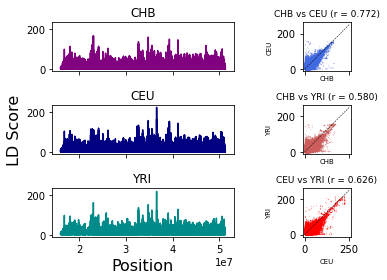

In [72]:
# Producing combined scatter and bar plots of LD scores

import matplotlib.pyplot as plt

# Filtering out LD scores of 0 
idx1 = (CHB_LDS_2 > 0) 
idx2 = (CEU_LDS_2 > 0) & (CHB_LDS_2 > 0)
idx3 = (CEU_LDS_2 > 0) 
idx4 = (CHB_LDS_2 > 0) & (YRI_LDS_2 > 0)
idx5 = (YRI_LDS_2 > 0) 
idx6 = (CEU_LDS_2 > 0) & (YRI_LDS_2 > 0)

fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,sharex='col',sharey='col')

# Plotting y = x
x = np.linspace(0,250,200)

# ax1, 3, 5 are bar plots, 2, 4, 6 are scatter
ax1.plot(pos[idx1],CHB_LDS_2[idx1],color='purple')
ax2.scatter(CHB_LDS_2[idx2], CEU_LDS_2[idx2],s=0.01,color='royalblue')
ax2.plot(x,x,color='black',linewidth=0.5,linestyle='--')
ax3.plot(pos[idx3],CEU_LDS_2[idx3],color='navy')
ax4.scatter(CHB_LDS_2[idx4], YRI_LDS_2[idx4],s=0.01,color='indianred')
ax4.plot(x,x,color='black',linewidth=0.5,linestyle='--')
ax5.plot(pos[idx5],YRI_LDS[idx5],color='darkcyan')
ax6.scatter(CEU_LDS_2[idx6], YRI_LDS_2[idx6],s=0.01,color='red')
ax6.plot(x,x,color='black',linewidth=0.5,linestyle='--')

# Setting x and y axis labels
ax2.set_xlabel("CHB", fontsize=7)
ax2.set_ylabel("CEU", fontsize=7)
ax3.set_ylabel('LD Score',fontsize=16)
ax4.set_xlabel('CHB',fontsize=7)
ax4.set_ylabel('YRI',fontsize=7)
ax5.set_xlabel("Position",fontsize=16)
ax6.set_xlabel("CEU",fontsize=7)
ax6.set_ylabel("YRI",fontsize=7)

# Make scatter plots squares rather than rectangles
x0,x1 = ax2.get_xlim()
y0,y1 = ax2.get_ylim()
ax2.set_aspect(abs(x1-x0)/abs(y1-y0))
x0,x1 = ax4.get_xlim()
y0,y1 = ax4.get_ylim()
ax4.set_aspect(abs(x1-x0)/abs(y1-y0))
x0,x1 = ax6.get_xlim()
y0,y1 = ax6.get_ylim()
ax6.set_aspect(abs(x1-x0)/abs(y1-y0))

# Setting titles for plots
ax1.title.set_text("CHB")
ax2.title.set_text("CHB vs CEU (r = 0.772)")
ax2.title.set_fontsize(9)
ax3.title.set_text("CEU")
ax4.title.set_text("CHB vs YRI (r = 0.580)")
ax4.title.set_fontsize(9)
ax5.title.set_text("YRI")
ax6.title.set_text("CEU vs YRI (r = 0.626)")
ax6.title.set_fontsize(9)

plt.tight_layout()
#plt.savefig('chr22_LDS_bar_scatter.png',dpi=300)

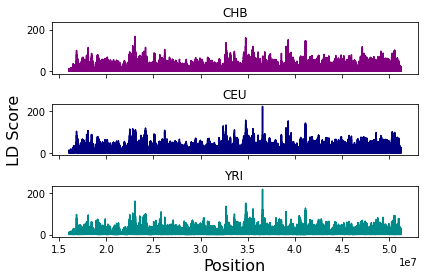

In [73]:
# Bar plots for entire chr22 to compare CHB/CEU/YRI populations

fig, (ax1,ax2,ax3) = plt.subplots(3,sharex=True,sharey=True)

# Filtering out LD scores of 0
idx1 = (CHB_LDS_2 > 0) 
idx2 = (CEU_LDS_2 > 0) 
idx3 = (YRI_LDS_2 > 0) 

ax1.plot(pos[idx1],CHB_LDS_2[idx1],color='purple')
ax2.plot(pos[idx2],CEU_LDS_2[idx2],color='navy')
ax3.plot(pos[idx3],YRI_LDS_2[idx3],color='darkcyan')

ax2.set_ylabel('LD Score',fontsize=16)
ax3.set_xlabel("Position",fontsize=16)

ax1.title.set_text("CHB")
ax2.title.set_text("CEU")
ax3.title.set_text("YRI")

plt.tight_layout()
#plt.savefig('chr22_LDS_bar.png',dpi=300)

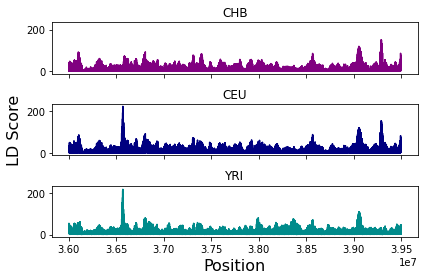

In [24]:
# Focusing on specific regions of chromosome 22 

fig, (ax1,ax2,ax3) = plt.subplots(3,sharex=True,sharey=True)

# Setting lower and upper bounds on positions to be observed
lowerb = 3.6*10**7
upperb = 3.95*10**7

idx4 = (pos[idx1] > lowerb) & (pos[idx1] < upperb)
idx5 = (pos[idx2] > lowerb) & (pos[idx2] < upperb)
idx6 = (pos[idx3] > lowerb) & (pos[idx3] < upperb)

ax1.plot(pos[idx1][idx4],CHB_LDS_2[idx1][idx4],color='purple')
ax2.plot(pos[idx2][idx5],CEU_LDS_2[idx2][idx5],color='navy')
ax3.plot(pos[idx3][idx6],YRI_LDS_2[idx3][idx6],color='darkcyan')

ax2.set_ylabel('LD Score',fontsize=16)
ax3.set_xlabel("Position",fontsize=16)

ax1.title.set_text("CHB")
ax2.title.set_text("CEU")
ax3.title.set_text("YRI")

plt.tight_layout()

#plt.savefig('chr22_LDS_bar_region2.png',dpi=300)

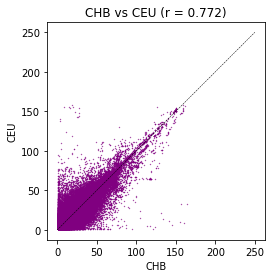

In [74]:
# Scatter plot for CHB vs CEU

idx = (CEU_LDS_2 > 0) & (CHB_LDS_2 > 0)

fig, ax = plt.subplots()
ax.scatter(CHB_LDS_2[idx],CEU_LDS_2[idx],s=0.1,color='purple')
ax.set_xlabel("CHB")
ax.set_ylabel("CEU")

x = np.linspace(0,250,200)
ax.plot(x, x, color='black',linewidth=0.5,linestyle='--')

x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))

ax.title.set_text("CHB vs CEU (r = 0.772)")

#np.corrcoef(CHB_LDS[idx],CEU_LDS[idx])
np.corrcoef(CHB_LDS_2,CEU_LDS_2)

#plt.savefig('CHBvsCEUscatter_chr22.png',dpi=300)

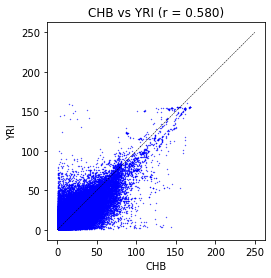

In [75]:
# Scatter plot for CHB vs YRI

idx = (CHB_LDS_2 > 0) & (YRI_LDS_2 > 0)

fig, ax = plt.subplots()
ax.scatter(CHB_LDS_2[idx],YRI_LDS_2[idx], s=0.1, color = 'blue')

ax.set_xlabel("CHB")
ax.set_ylabel("YRI")

ax.plot(x,x,color='black',linewidth=0.5,linestyle='--')

x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))

ax.title.set_text("CHB vs YRI (r = 0.580)")

#np.corrcoef(CHB_LDS[idx],YRI_LDS[idx])
np.corrcoef(CHB_LDS_2,YRI_LDS_2)

#plt.savefig('CHBvsYRIscatter_chr22.png',dpi=300)

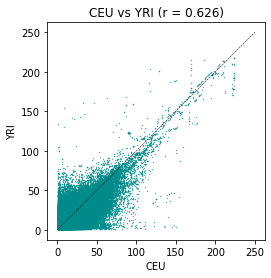

In [76]:
# Scatter plot for CEU vs YRI

idx = (CEU_LDS_2 > 0) & (YRI_LDS_2 > 0)

fig, ax = plt.subplots()
ax.scatter(CEU_LDS_2[idx],YRI_LDS_2[idx], s=0.1, color='darkcyan')

ax.set_xlabel("CEU")
ax.set_ylabel("YRI")

ax.plot(x,x,color='black',linewidth=0.5,linestyle='--')

x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))

ax.title.set_text("CEU vs YRI (r = 0.626)")

#np.corrcoef(CEU_LDS[idx],YRI_LDS[idx])
np.corrcoef(CEU_LDS_2,YRI_LDS_2)

#plt.savefig('CEUvsYRIscatter_chr22.png',dpi=300)